# Notebook for looking at photon yield / percentage for diff theta, phi

In [1]:
#imports
import numpy as np
import uproot as up
import pandas as pd
import matplotlib.pyplot as plot
from scipy.stats import norm
from scipy.optimize import curve_fit
import sympy
from IPython.display import clear_output
import math
import time
import util
import multiprocessing
import time
#My imports
from util import PVect,get_layer,create_layer_map,theta_func,phi_func,findBin,bin_percent_theta_phi
import os

Using device cuda:0


In [2]:
groupdir_pref = "/hpc/group/vossenlab/rck32/"

In [3]:
layer_map,super_layer_map = create_layer_map()
n_bins = 30

z_min = -770
z_max = 770

z_bins = np.linspace(z_min,z_max,n_bins+1)
#calc z hit pos from x pos, px pz
def dz_func(dx, px, pz):
    return dx * pz / px
#works only for evenly spaced bins
def findBin(val,bins):
    diff = bins[1] - bins[0]
    rel_dist = val - bins[0]
    mod = np.floor(rel_dist / diff)
    return int(mod)
z_bin_centers = np.empty(n_bins)
for i in range(len(z_bins) - 1):
    z_bin_centers[i] = (z_bins[i] + z_bins[i+1]) / 2
z_bin_centers_dis = 770 - z_bin_centers    

# % photons as function of z hit pos

## Use this for single files

In [4]:
particle = "mu"
energy = "5"
color_dict = {
    "pi" : "red",
    "mu" : "blue"
}

#Sept 5th 2024: New data for fitting curve and double checking relationship:
def extract_photon_yield_one_file(uproot_path):
#     print("starting process")
    events = up.open(uproot_path)

    x_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.x"].array(library='np')
    EDep_branch = events["HcalBarrelHits.EDep"].array(library='np')
    Pathlength_branch = events["HcalBarrelHits.pathLength"].array(library='np')
    Hits_MC_idx_branch = events["_HcalBarrelHits_MCParticle.index"].array(library='np')
    MC_parents = events["_MCParticles_parents.index"].array(library='np')
    MC_daughters = events["MCParticles.daughters_end"].array(library='np')
    PDG_branch = events["MCParticles.PDG"].array(library='np')
    MC_endpoint_x_branch = events["MCParticles.endpoint.x"].array(library='np')

    time_branch = events["HcalBarrelHits.time"].array(library='np')
    layer_map = [1830.8000, 1841.4000, 1907.5, 1918.1,1984.1999, 1994.8000, 2060.8999,2071.5,2137.6001,2148.1999,2214.3000,2224.8999,2291,2301.6001,2367.6999,2378.3000,2444.3999,2455,2521.1001,2531.6999,2597.8000,2608.3999,2674.5,2685.1001,2751.1999,2761.8000,2827.8999,2838.5]    

    MC_px = events["MCParticles.momentum.x"].array(library='np')
    MC_py = events["MCParticles.momentum.y"].array(library='np')
    MC_pz = events["MCParticles.momentum.z"].array(library='np')
    MC_m = events["MCParticles.mass"].array(library='np')
    MC_vertex_x = events["MCParticles.vertex.x"].array(library='np')
    MC_vertex_z = events["MCParticles.vertex.z"].array(library='np')
#     print("loaded all branches")


    z_percent = np.zeros(n_bins)
    num_events = len(EDep_branch)

    z_MC = np.zeros(n_bins)

    z_hits = np.zeros(n_bins)

    num_MC = 0
    num_hits = 0
    energy_dep = 0
    dep_count = 0
    hits_per_photon = []
    break_val = 1000
#     print("starting loop")
    for event_idx in range(len(EDep_branch)):
#         if(not (event_idx % (break_val // 100))):
#             clear_output(wait = True)
#             print(f"{event_idx // (break_val // 100)}% done")
        num_MC = 0
        primary = PVect()
        primary.setVector(MC_px[event_idx][0],MC_py[event_idx][0],MC_pz[event_idx][0],MC_m[event_idx][0])
        dx = 1770 - MC_vertex_x[event_idx][0]  #first layer at approx 1770
        z_hit_pos = dz_func(dx,primary.px,primary.pz) + MC_vertex_z[event_idx][0]
        z_bin = findBin(z_hit_pos,z_bins)
        for i in range(len(PDG_branch[event_idx])):
            if(PDG_branch[event_idx][i] == -22 and (i < MC_daughters[event_idx][0])):
                z_MC[z_bin] += 1
        for hit in range(len(EDep_branch[event_idx])):
            if(PDG_branch[event_idx][Hits_MC_idx_branch[event_idx][hit]] == -22):
                z_hits[z_bin] += 1
        if(event_idx > break_val):
            break
    return z_hits, z_MC

In [ ]:
uproot_file_dir = groupdir_pref + "eic/work_eic/root_files/Photon_yield_param/run_2_no_QE/"

output = extract_photon_yield_one_file(uproot_file_dir + f"x_1769_3_vary_z_th_1kevents_0_30_z_vals.edm4hep.root:events")

output

In [ ]:
eic_pref = "/hpc/group/vossenlab/rck32/eic/"

uproot_file_dir = groupdir_pref + "eic/work_eic/root_files/Photon_yield_param/run_2_no_QE/"
file_list = []
for i in range(31):
    file_list.append(uproot_file_dir + f"x_1769_3_vary_z_th_1kevents_{i}_30_z_vals.edm4hep.root:events")
z_hits = np.zeros(n_bins)
z_MC = np.zeros(n_bins)
with multiprocessing.Pool() as pool:
    results_list = pool.map(extract_photon_yield_one_file, file_list)
results_np = np.array(results_list)
np.save(groupdir_pref + "eic/work_eic/macros/Timing_estimation/data/photon_yield/october_20_run_2_no_qe/data",results_np)

In [ ]:
for i in range(len(results_list)):
    z_hits += results_list[i][0]
    z_MC += results_list[i][1]

In [ ]:
z_percent = z_hits / z_MC * 100
z_bin_centers_dis = 770 - z_bin_centers

In [ ]:
plot.scatter(z_bin_distances,z_percent);

In [ ]:
fig, ax1 = plot.subplots(1,1, figsize=(7,5))
fig.suptitle("Percentage of photons reaching sensor as a fraction of total photons generated")
ax1.set_ylabel("percentage")
ax1.scatter(z_bin_centers_dis,z_percent,color = "blue")
ax1.set_xlabel("z (distance from sensor)")
fig.show()
# fig.savefig("plots/percentage/June_14_mu_5GeV_10k_phi_theta_20_bins.jpeg")

In [34]:
def inverse(x,a,b,c):
    return a  / (x + b) + c

In [35]:
fit_percent = []
fit_bins = []
for i in range(n_bins):
    if(np.isnan(z_percent[i])):
        continue
    fit_percent.append(z_percent[i])
    fit_bins.append(z_bin_centers_dis[i])

In [40]:
popt_z, pcov_z = curve_fit(inverse,fit_bins,fit_percent)
fit_x = np.linspace(25,1500,200)
z_fit = inverse(fit_x,*popt_z)
z_fit_no_QE = inverse(fit_x,494.98,9.9733,-0.16796)

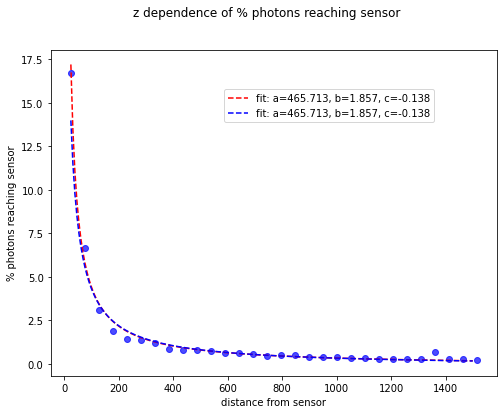

In [42]:
fig_z, ax_z = plot.subplots(1,1, figsize = (8,6))
ax_z.plot(fit_x,z_fit, 'r--',label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt_z))
ax_z.plot(fit_x,z_fit_no_QE, 'b--',label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt_z))
fig_z.suptitle("z dependence of % photons reaching sensor")
ax_z.scatter(fit_bins,fit_percent,color="blue", alpha = 0.7)
ax_z.set_xlabel("distance from sensor")
ax_z.set_ylabel("% photons reaching sensor")
fig_z.legend(bbox_to_anchor=(0.8, 0.8))

In [38]:
popt_z

array([ 4.65713433e+02,  1.85721637e+00, -1.38278415e-01])